<a href="https://colab.research.google.com/github/maitysuvo19/internship_root2ai_classify_text/blob/main/root2ai_claasification_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv('/content/root2ai - Data.csv')

In [3]:
df.head()

,Text,Target
0,reserve bank forming expert committee based in...,Blockchain
1,director could play role financial system,Blockchain
2,preliminary discuss secure transaction study r...,Blockchain
3,security indeed prove essential transforming f...,Blockchain
4,bank settlement normally take three days based...,Blockchain


In [4]:
df=df.dropna()
df.reset_index(drop=True)

,Text,Target
0,reserve bank forming expert committee based in...,Blockchain
1,director could play role financial system,Blockchain
2,preliminary discuss secure transaction study r...,Blockchain
3,security indeed prove essential transforming f...,Blockchain
4,bank settlement normally take three days based...,Blockchain
...,...,...
22696,fourth study discusses blockchain technology e...,Reg Tech
22697,book finishes stating biggest issue emerging F...,Reg Tech
22698,people culture cess,Reg Tech
22699,author challenges execu tive lead change stop ...,Reg Tech


In [5]:
df.isnull().any()

Text      False
Target    False
dtype: bool

In [6]:
df["Target"].value_counts()/df.shape[0]

FinTech             0.376679
Cyber Security      0.116294
Bigdata             0.099863
Reg Tech            0.097176
credit reporting    0.077001
Blockchain          0.060570
Neobanks            0.047090
Microservices       0.042906
Stock Trading       0.034668
Robo Advising       0.032466
Data Security       0.015286
Name: Target, dtype: float64

In [7]:
#importing a few necessary packages and setting the DATA directory
DATA_DIR="."
import pickle
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore") 

In [8]:
# install BERT
!pip install pytorch_pretrained_bert pytorch-nlp

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

In [9]:
from sklearn.preprocessing import LabelEncoder

#sentiment is positive and negative we need to convert it to 0,1
le = LabelEncoder()
df["Target"] = le.fit_transform(df["Target"])

In [10]:
df['Target'].value_counts()

4     8551
2     2640
0     2267
7     2206
10    1748
1     1375
6     1069
5      974
9      787
8      737
3      347
Name: Target, dtype: int64

In [11]:
#cleaning the text
from bs4 import BeautifulSoup
import re

def strip(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub('\[[^]]*\]', '', soup.get_text())
    pattern=r"[^a-zA-z0-9\s,']"
    text=re.sub(pattern,'',text)
    return text

df['Text']=df['Text'].apply(strip)

In [12]:
df.head()

,Text,Target
0,reserve bank forming expert committee based in...,1
1,director could play role financial system,1
2,preliminary discuss secure transaction study r...,1
3,security indeed prove essential transforming f...,1
4,bank settlement normally take three days based...,1


In [13]:
#BERT needs to understand 2 things:
#1) The start and end of each sentiment
# so we declare a special token CLS which tells BERT that its a classification task
sentences = df['Text']
sentence = ["[CLS] "+i+" [SEP]" for i in sentences]

In [14]:
sentence[0]

'[CLS] reserve bank forming expert committee based institute development research banking technology study approach distributed ledger technology help support shift [SEP]'

In [15]:
# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Restricting the max size of Tokens to 512(BERT doest accept any more than this)
tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:510] , sentence))
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'reserve', 'bank', 'forming', 'expert', 'committee', 'based', 'institute', 'development', 'research', 'banking', 'technology', 'study', 'approach', 'distributed', 'ledger', 'technology', 'help', 'support', 'shift', '[SEP]']


In [16]:
labels = list(df['Target'])#storing the labels

In [17]:
# Set the maximum sequence length. 
MAX_LEN = 128

# Pad our input tokens so that everything has a uniform length
input_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, tokenized_texts)),
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [18]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [19]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [20]:
# Select a batch size for training. 
batch_size = 16

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [21]:
CUDA_LAUNCH_BLOCKING=1

In [22]:
#Loading pre trained BERT
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=11)#binary classification
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [23]:
CUDA_LAUNCH_BLOCKING=1

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 1.2638157682672737


Epoch:  25%|██▌       | 1/4 [10:10<30:30, 610.24s/it]

Validation Accuracy: 0.6627347417840376
Train loss: 0.8043908065618158


Epoch:  50%|█████     | 2/4 [20:21<20:20, 610.45s/it]

Validation Accuracy: 0.6944542253521127
Train loss: 0.5237011943091241


Epoch:  75%|███████▌  | 3/4 [30:32<10:10, 610.65s/it]

Validation Accuracy: 0.7050176056338028
Train loss: 0.3204634381004535


Epoch: 100%|██████████| 4/4 [40:43<00:00, 610.95s/it]

Validation Accuracy: 0.7195715962441314


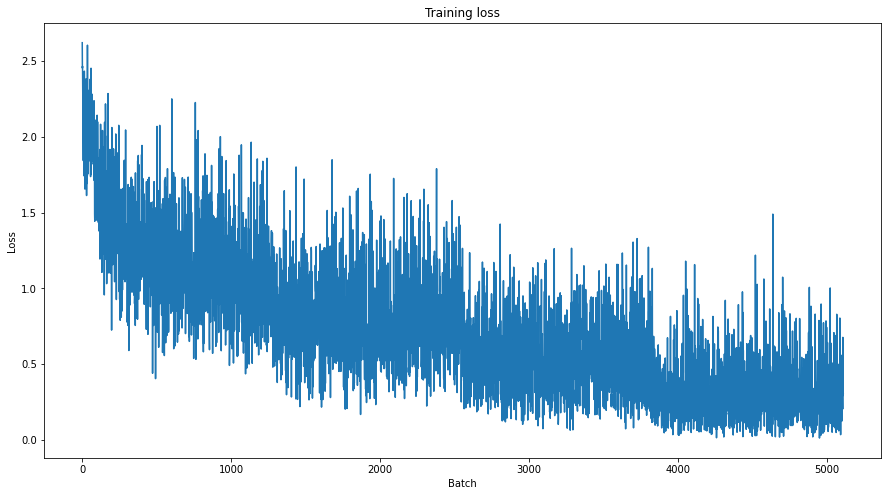

In [24]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

torch.cuda.empty_cache() 
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4
# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()